In [1]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 15725 (delta 201), reused 302 (delta 103), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (11313/11313), done.
/content/detectron2


In [2]:
!pip install -e .

Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=475c137a7233a804bea91524e2c516d7ffaf0d7bd0ab2be1fca28e7d99640c4c
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=78a10185de0998abbdd0208a4da0bbce9477145adb329892

In [1]:
%cd detectron2

/content/detectron2


In [2]:
!curl -L "https://universe.roboflow.com/ds/c33ZffCxu8?key=pTQC7sF6z8" --output roboflow.zip && unzip roboflow.zip -d minecraft_dataset/ && rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   902  100   902    0     0   3353      0 --:--:-- --:--:-- --:--:--  3365
100  422M  100  422M    0     0  49.3M      0  0:00:08  0:00:08 --:--:-- 59.2M
Archive:  roboflow.zip
 extracting: minecraft_dataset/README.dataset.txt  
 extracting: minecraft_dataset/README.roboflow.txt  
   creating: minecraft_dataset/test/
 extracting: minecraft_dataset/test/-20-_jpg.rf.b6e634a136dcfb16a7a07cda96072ab8.jpg  
 extracting: minecraft_dataset/test/-21-_jpg.rf.23982f2775c558c4c37a09bbaa2208b4.jpg  
 extracting: minecraft_dataset/test/-22-_jpg.rf.5e6e148f7c954ad021a5ef8eb50ed754.jpg  
 extracting: minecraft_dataset/test/-23-_jpg.rf.7d5cfa31d7e87f62f5578b045ffad4e6.jpg  
 extracting: minecraft_dataset/test/-24-_jpg.rf.075ddd9e73000ea2479d2c8c7473360e.jpg  
 extracting: minecraft_dataset/test/-25-_jpg.rf.a0dcd42afe0121abb9a8a1be6337c60c.jpg

In [2]:
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import torch

import os
import random
import json
import numpy as np
import cv2

from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
if torch.cuda.is_available():
  generator = torch.Generator('cuda').manual_seed(25)
else:
  generator = torch.Generator().manual_seed(25)

In [4]:
register_coco_instances("mc_dataset_train", {}, "/content/detectron2/minecraft_dataset/train/_annotations.coco.json", "/content/detectron2/minecraft_dataset/train")
register_coco_instances("mc_dataset_val", {}, "/content/detectron2/minecraft_dataset/valid/_annotations.coco.json", "/content/detectron2/minecraft_dataset/valid")
register_coco_instances("mc_dataset_test", {}, "/content/detectron2/minecraft_dataset/test/_annotations.coco.json", "/content/detectron2/minecraft_dataset/test")

my_dataset_train_metadata = MetadataCatalog.get("mc_dataset_train")
dataset_dicts = DatasetCatalog.get("mc_dataset_train")

WARNING [06/06 18:28:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 18:28:05 d2.data.datasets.coco]: Loaded 2307 images in COCO format from /content/detectron2/minecraft_dataset/train/_annotations.coco.json


In [5]:
len(my_dataset_train_metadata.thing_classes)

18

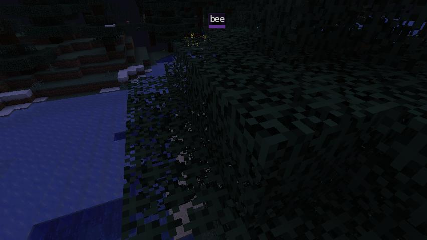

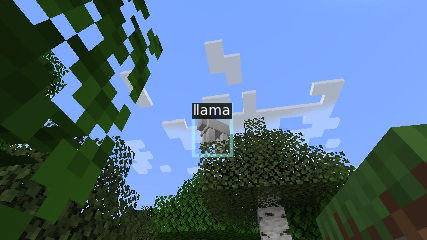

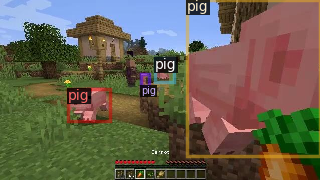

In [6]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mc_dataset_train",)
cfg.DATASETS.TEST = ("mc_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (1000, 1200)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(my_dataset_train_metadata.thing_classes)

cfg.TEST.EVAL_PERIOD = 500

In [8]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
# !pip install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117

In [10]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 18:28:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/06 18:28:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/06 18:28:39 d2.utils.events]:  eta: 0:22:51  iter: 19  total_loss: 3.808  loss_cls: 3.147  loss_box_reg: 0.6658  loss_rpn_cls: 0.0193  loss_rpn_loc: 0.00866    time: 0.9378  last_time: 0.8690  data_time: 0.0584  last_data_time: 0.0110   lr: 1.9981e-05  max_mem: 4690M
[06/06 18:29:03 d2.utils.events]:  eta: 0:22:48  iter: 39  total_loss: 3.311  loss_cls: 2.63  loss_box_reg: 0.5596  loss_rpn_cls: 0.03715  loss_rpn_loc: 0.01301    time: 0.9759  last_time: 0.8288  data_time: 0.0434  last_data_time: 0.0298   lr: 3.9961e-05  max_mem: 4690M
[06/06 18:29:23 d2.utils.events]:  eta: 0:22:43  iter: 59  total_loss: 2.357  loss_cls: 1.742  loss_box_reg: 0.7015  loss_rpn_cls: 0.02884  loss_rpn_loc: 0.01543    time: 0.9702  last_time: 0.9600  data_time: 0.0309  last_data_time: 0.0275   lr: 5.9941e-05  max_mem: 4690M
[06/06 18:29:42 d2.utils.events]:  eta: 0:22:33  iter: 79  total_loss: 1.828  loss_cls: 1.043  loss_box_reg: 0.7406  loss_rpn_cls: 0.04037  loss_rpn_loc: 0.009371    time: 0.9727  las

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 18:36:58 d2.evaluation.evaluator]: Inference done 11/422. Dataloading: 0.0060 s/iter. Inference: 0.1223 s/iter. Eval: 0.0004 s/iter. Total: 0.1286 s/iter. ETA=0:00:52
[06/06 18:37:03 d2.evaluation.evaluator]: Inference done 51/422. Dataloading: 0.0063 s/iter. Inference: 0.1218 s/iter. Eval: 0.0004 s/iter. Total: 0.1287 s/iter. ETA=0:00:47
[06/06 18:37:08 d2.evaluation.evaluator]: Inference done 81/422. Dataloading: 0.0095 s/iter. Inference: 0.1344 s/iter. Eval: 0.0006 s/iter. Total: 0.1448 s/iter. ETA=0:00:49
[06/06 18:37:13 d2.evaluation.evaluator]: Inference done 113/422. Dataloading: 0.0101 s/iter. Inference: 0.1374 s/iter. Eval: 0.0010 s/iter. Total: 0.1489 s/iter. ETA=0:00:46
[06/06 18:37:18 d2.evaluation.evaluator]: Inference done 153/422. Dataloading: 0.0086 s/iter. Inference: 0.1330 s/iter. Eval: 0.0008 s/iter. Total: 0.1427 s/iter. ETA=0:00:38
[06/06 18:37:23 d2.evaluation.evaluator]: Inference done 190/422. Dataloading: 0.0084 s/iter. Inference: 0.1321 s/iter. Eval: 0.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 18:46:37 d2.evaluation.evaluator]: Inference done 11/422. Dataloading: 0.0108 s/iter. Inference: 0.1647 s/iter. Eval: 0.0004 s/iter. Total: 0.1759 s/iter. ETA=0:01:12
[06/06 18:46:42 d2.evaluation.evaluator]: Inference done 42/422. Dataloading: 0.0137 s/iter. Inference: 0.1510 s/iter. Eval: 0.0009 s/iter. Total: 0.1658 s/iter. ETA=0:01:03
[06/06 18:46:47 d2.evaluation.evaluator]: Inference done 82/422. Dataloading: 0.0099 s/iter. Inference: 0.1340 s/iter. Eval: 0.0006 s/iter. Total: 0.1447 s/iter. ETA=0:00:49
[06/06 18:46:52 d2.evaluation.evaluator]: Inference done 121/422. Dataloading: 0.0091 s/iter. Inference: 0.1305 s/iter. Eval: 0.0006 s/iter. Total: 0.1403 s/iter. ETA=0:00:42
[06/06 18:46:57 d2.evaluation.evaluator]: Inference done 150/422. Dataloading: 0.0107 s/iter. Inference: 0.1354 s/iter. Eval: 0.0007 s/iter. Total: 0.1470 s/iter. ETA=0:00:39
[06/06 18:47:02 d2.evaluation.evaluator]: Inference done 184/422. Dataloading: 0.0111 s/iter. Inference: 0.1354 s/iter. Eval: 0.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 18:56:24 d2.evaluation.evaluator]: Inference done 11/422. Dataloading: 0.0016 s/iter. Inference: 0.1178 s/iter. Eval: 0.0004 s/iter. Total: 0.1198 s/iter. ETA=0:00:49
[06/06 18:56:29 d2.evaluation.evaluator]: Inference done 52/422. Dataloading: 0.0045 s/iter. Inference: 0.1181 s/iter. Eval: 0.0004 s/iter. Total: 0.1232 s/iter. ETA=0:00:45
[06/06 18:56:34 d2.evaluation.evaluator]: Inference done 90/422. Dataloading: 0.0053 s/iter. Inference: 0.1215 s/iter. Eval: 0.0004 s/iter. Total: 0.1272 s/iter. ETA=0:00:42
[06/06 18:56:39 d2.evaluation.evaluator]: Inference done 122/422. Dataloading: 0.0077 s/iter. Inference: 0.1284 s/iter. Eval: 0.0004 s/iter. Total: 0.1366 s/iter. ETA=0:00:40
[06/06 18:56:44 d2.evaluation.evaluator]: Inference done 159/422. Dataloading: 0.0080 s/iter. Inference: 0.1281 s/iter. Eval: 0.0004 s/iter. Total: 0.1367 s/iter. ETA=0:00:35
[06/06 18:56:49 d2.evaluation.evaluator]: Inference done 200/422. Dataloading: 0.0069 s/iter. Inference: 0.1262 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 18:57:21 d2.evaluation.evaluator]: Total inference time: 0:00:57.493590 (0.137874 s / iter per device, on 1 devices)
[06/06 18:57:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:53 (0.129279 s / iter per device, on 1 devices)
[06/06 18:57:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 18:57:21 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[06/06 18:57:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[06/06 18:57:21 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[06/06 18:57:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.17 seconds.
[06/06 18:57:21 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[06/06 18:57:21 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.05 seconds.
 Average Precision  (AP

In [12]:
!cp -r /content/detectron2/output /content/drive/MyDrive/cmp719_project/detectrons/minecraft_model

In [11]:
cfg.OUTPUT_DIR

'./output'

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/06 18:59:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [06/06 18:59:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 18:59:29 d2.data.datasets.coco]: Loaded 422 images in COCO format from /content/detectron2/minecraft_dataset/valid/_annotations.coco.json


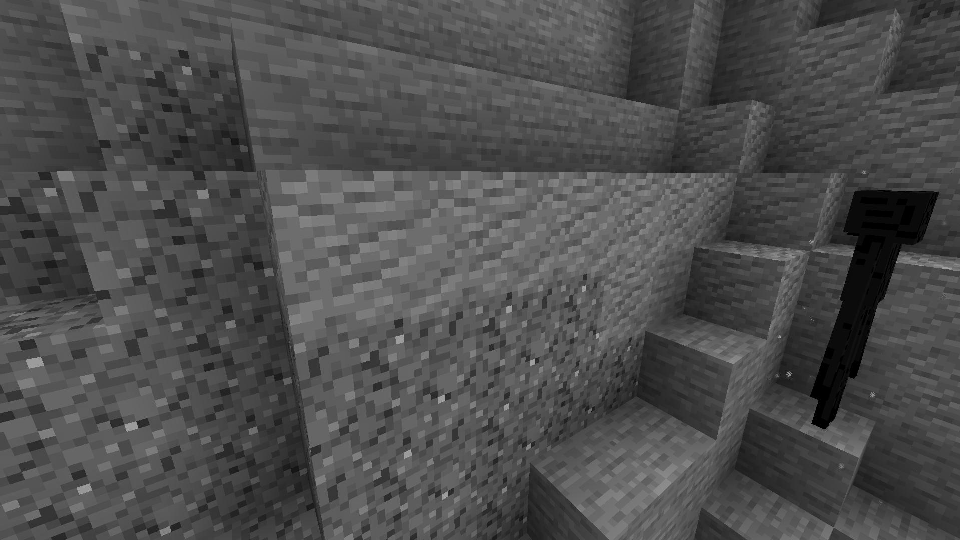

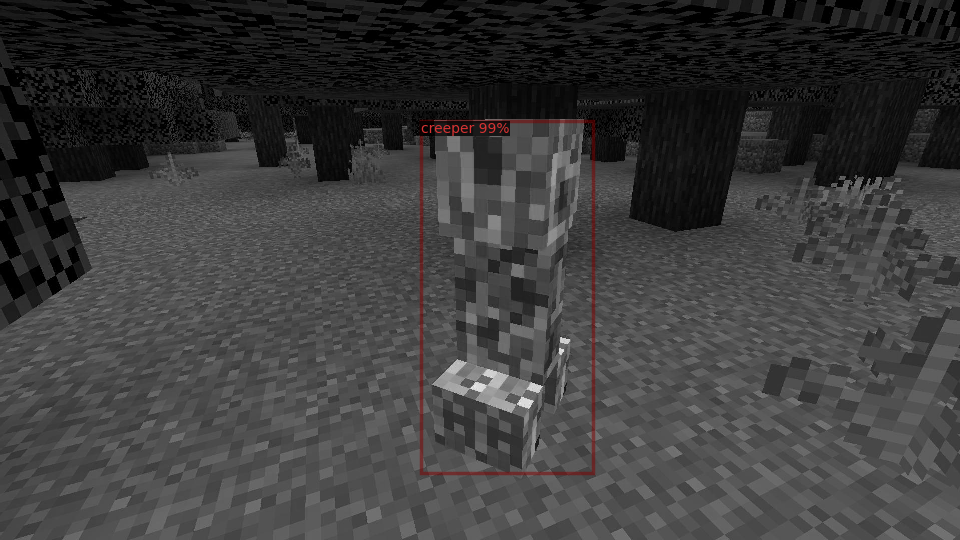

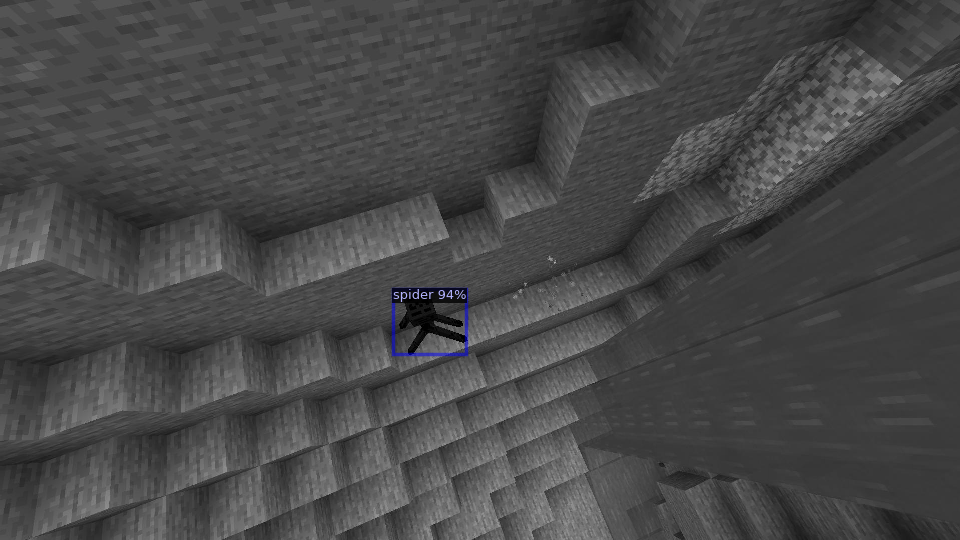

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("mc_dataset_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("mc_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "mc_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/06 18:59:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 18:59:37 d2.data.datasets.coco]: Loaded 422 images in COCO format from /content/detectron2/minecraft_dataset/valid/_annotations.coco.json
[06/06 18:59:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 18:59:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/06 18:59:37 d2.data.common]: Serializing 422 elements to byte tensors and concatenating them all ...
[06/06 18:59:37 d2.data.common]: Serialized dataset takes 0.14 MiB
[06/06 18:59:37 d2.evaluation.evaluator]: Start inference on 422 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 18:59:39 d2.evaluation.evaluator]: Inference done 11/422. Dataloading: 0.0102 s/iter. Inference: 0.1440 s/iter. Eval: 0.0002 s/iter. Total: 0.1543 s/iter. ETA=0:01:03
[06/06 18:59:44 d2.evaluation.evaluator]: Inference done 43/422. Dataloading: 0.0144 s/iter. Inference: 0.1426 s/iter. Eval: 0.0005 s/iter. Total: 0.1577 s/iter. ETA=0:00:59
[06/06 18:59:49 d2.evaluation.evaluator]: Inference done 77/422. Dataloading: 0.0124 s/iter. Inference: 0.1397 s/iter. Eval: 0.0004 s/iter. Total: 0.1527 s/iter. ETA=0:00:52
[06/06 18:59:55 d2.evaluation.evaluator]: Inference done 118/422. Dataloading: 0.0092 s/iter. Inference: 0.1328 s/iter. Eval: 0.0003 s/iter. Total: 0.1426 s/iter. ETA=0:00:43
[06/06 19:00:00 d2.evaluation.evaluator]: Inference done 156/422. Dataloading: 0.0083 s/iter. Inference: 0.1320 s/iter. Eval: 0.0004 s/iter. Total: 0.1409 s/iter. ETA=0:00:37
[06/06 19:00:05 d2.evaluation.evaluator]: Inference done 187/422. Dataloading: 0.0088 s/iter. Inference: 0.1350 s/iter. Eval: 0.